In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import Input
from keras.models import load_model
#import tensorflow as tf
#from tensorflow import keras
from keras_preprocessing.image import load_img, ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

In [54]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

#base_model = InceptionV3(include_top=False,
#                         input_shape=(150, 150, 3),
#                        weights = 'imagenet')
#
base_model.trainable = False

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [55]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True
                              )
#rescale=1/255.)

train_ds = train_gen.flow_from_directory('../Week8/clothing-dataset-small/train/',
                                         target_size=(300,300),                              
                                         batch_size=20)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)#rescale=1/255.)

val_ds = val_gen.flow_from_directory('../Week8/clothing-dataset-small/validation/',
                                     target_size=(300,300),
                                     batch_size=20)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [56]:
inputs = Input(shape=(300,300,3))
base = base_model(inputs, training=False)

#base = last_layer_out.output
#x = layers.Flatten()(base_model.output)
vectors = layers.GlobalAveragePooling2D()(base)

#x = layers.Dense(16, activation='relu')(x)
inner = layers.Dense(128, activation='relu')(vectors)
drop = layers.Dropout(0.2)(inner)
outputs = layers.Dense(10)(drop)
#model = keras.Model(inputs, outputs)

from tensorflow.keras import Model

#modelx = Model(base_model.input, x)
modelx = Model(inputs, outputs)

optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy(from_logits=True)

modelx.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [57]:
history = modelx.fit(train_ds,
                     validation_data=val_ds,
                     steps_per_epoch=50,
                     epochs=10,
                     #validation_steps=5,
                     #verbose=2
                    )

Epoch 1/10
50/50 [==============================] - 26s 458ms/step - loss: 1.4866 - accuracy: 0.5190 - val_loss: 1.1080 - val_accuracy: 0.6276
Epoch 2/10
50/50 [==============================] - 89s 2s/step - loss: 1.1077 - accuracy: 0.6370 - val_loss: 0.9427 - val_accuracy: 0.6510
Epoch 3/10
50/50 [==============================] - 28s 498ms/step - loss: 0.9421 - accuracy: 0.6953 - val_loss: 0.8349 - val_accuracy: 0.7273
Epoch 4/10
50/50 [==============================] - 20s 391ms/step - loss: 0.9175 - accuracy: 0.6872 - val_loss: 0.8383 - val_accuracy: 0.7185
Epoch 5/10
50/50 [==============================] - 33s 674ms/step - loss: 0.8422 - accuracy: 0.6970 - val_loss: 0.7819 - val_accuracy: 0.7595
Epoch 6/10
50/50 [==============================] - 20s 402ms/step - loss: 0.8096 - accuracy: 0.7227 - val_loss: 0.8440 - val_accuracy: 0.7155
Epoch 7/10
50/50 [==============================] - 20s 392ms/step - loss: 0.7618 - accuracy: 0.7380 - val_loss: 0.7916 - val_accuracy: 0.7331
Ep

In [58]:
modelx.save('clothing_model.h5')

C:\Users\MacCasa\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


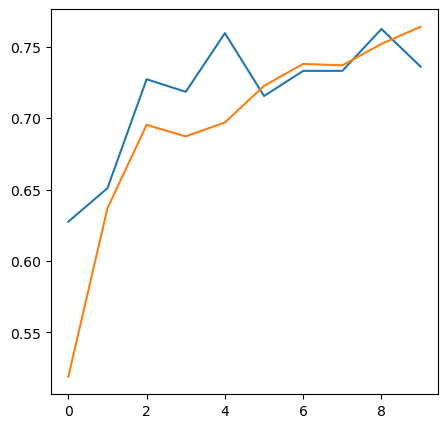

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))

ax = plt.plot(history.history['val_accuracy'], label='Val')
ax = plt.plot(history.history['accuracy'], label='Train')
    
plt.show()    

In [66]:
img2 = load_img('pants.jpg', target_size=(300,300))

x = np.array(img2)
X = np.array([x])
X = preprocess_input(X)

pred = modelx.predict(X)

values = ['dress', 'hat', 'longsleeve',  'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']

list(zip(values, pred[0]))

[('dress', -0.6620247),
 ('hat', -1.8277134),
 ('longsleeve', -1.197138),
 ('outwear', -1.0185655),
 ('pants', 6.917297),
 ('shirt', -1.7254003),
 ('shoes', -0.7698058),
 ('shorts', 2.9483626),
 ('skirt', -0.23238386),
 ('t-shirt', -2.0033824)]

### TF-Lite Conversion

In [67]:
import tensorflow.lite as tflite
from keras_preprocessing.image import load_img
from keras.applications.xception import preprocess_input

In [68]:
model = load_model('clothing_model.h5')

In [69]:
converter = tflite.TFLiteConverter.from_keras_model(model)
tfLiteModel = converter.convert()

with open('clothing_model.tflite', 'wb') as f:
    f.write(tfLiteModel)

INFO:tensorflow:Assets written to: C:\Users\MacCasa\AppData\Local\Temp\tmp_8bjnvsr\assets


INFO:tensorflow:Assets written to: C:\Users\MacCasa\AppData\Local\Temp\tmp_8bjnvsr\assets
C:\Users\MacCasa\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [70]:
!dir

 Volume in drive D is Data
 Volume Serial Number is 168D-18A7

 Directory of D:\Coding\MLZoomcamp\Week9

11/11/2022  10:28 PM    <DIR>          .
11/11/2022  10:28 PM    <DIR>          ..
11/11/2022  10:01 PM    <DIR>          .ipynb_checkpoints
11/11/2022  10:24 PM        86,891,440 clothing_model.h5
11/11/2022  10:28 PM        84,230,508 clothing_model.tflite
11/06/2022  09:39 PM            19,257 pants.jpg
11/11/2022  10:28 PM           303,097 TF_Lite.ipynb
               4 File(s)    171,444,302 bytes
               3 Dir(s)  937,770,622,976 bytes free


In [71]:
interpreter = tflite.Interpreter(model_path='clothing_model.tflite')
interpreter.allocate_tensors()

inputIdx = interpreter.get_input_details()[0]['index']

outputIdx = interpreter.get_output_details()[0]['index']

interpreter.set_tensor(inputIdx, X)

interpreter.invoke()

preds = interpreter.get_tensor(outputIdx)

values = ['dress', 'hat', 'longsleeve',  'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']

list(zip(values, pred[0]))

[('dress', -0.6620247),
 ('hat', -1.8277134),
 ('longsleeve', -1.197138),
 ('outwear', -1.0185655),
 ('pants', 6.917297),
 ('shirt', -1.7254003),
 ('shoes', -0.7698058),
 ('shorts', 2.9483626),
 ('skirt', -0.23238386),
 ('t-shirt', -2.0033824)]

### Remove TF dependency

In [72]:
from PIL import Image

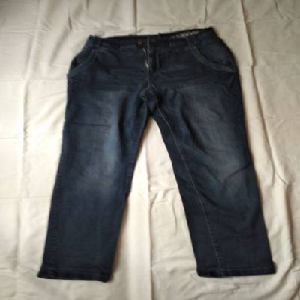

In [73]:
with Image.open('pants.jpg') as img:
    img = img.resize((300,300), Image.Resampling.NEAREST)
img    

In [74]:
def preprocess_input(x):
    x /= 127.5
    x -= -1.
    return x

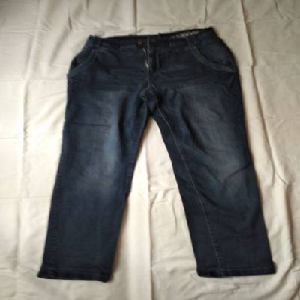

In [75]:
x = np.array(img, dtype='float32')
X = np.array([x])
X = preprocess_input(X)
img

In [77]:
interpreter2 = tflite.Interpreter(model_path='clothing_model.tflite')

interpreter2.allocate_tensors()

inputIdx = interpreter2.get_input_details()[0]['index']

outputIdx = interpreter2.get_output_details()[0]['index']

interpreter2.set_tensor(inputIdx, X)

interpreter2.invoke()

preds = interpreter2.get_tensor(outputIdx)

values = ['dress', 'hat', 'longsleeve',  'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']

list(zip(values, pred[0]))

[('dress', -0.6620247),
 ('hat', -1.8277134),
 ('longsleeve', -1.197138),
 ('outwear', -1.0185655),
 ('pants', 6.917297),
 ('shirt', -1.7254003),
 ('shoes', -0.7698058),
 ('shorts', 2.9483626),
 ('skirt', -0.23238386),
 ('t-shirt', -2.0033824)]